<h1>Изучение закономерностей, определяющих успешность игры</h1>

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Мне нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

<h2>Изучение данных</h2>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

In [6]:
games = pd.read_csv('games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В целом вид данных понятен, видны пропуски и неверные типы данных.

<h2>Предобработка данных</h2>

<h3>Обработка пропусков</h3>

In [8]:
games.columns = games.columns.str.lower()

In [9]:
display(games.query('name.isna()'))
games = games.dropna(subset=['name']).reset_index(drop=True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всего 2 строки не содержат названия и жанра, они также не содержат информацию о рейтинге, поэтому я не буду учитывать их в исследовании и удалю.

In [10]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('NaN')

Заполнил пропуски в данных:
<ul>
<li>Аббревиатура tbd, которой заполнены некоторые строки в столбце с оценкой пользователя, означает "to be determined" и используется в качестве заполнительного термина для информации, которую пользователь предоставит в будущем. Я заменил это значение на NaN, так как для нас эта аббревиатура значения не имеет.</li>
<li>Не заполнил пропуски в оценках критиков и пользователей, так как их много и это может негативно повлиять на точность исследования.</li>
<li>Не стал заполнять значения года и рейтинга от организации ESRB, так как это категориальные значения, их не получится просто заполнить медианной.</li>
</ul>
Возможные причины пропусков:
<ul>
<li>Пропуски в значении года выпуска может быть технической ошибкой, так как значение отсутствует у небольшго количества игр.</li>
<li>Пропуски в оценке критиков и пользователей не случайны. Вероятнее всего, их нет у непопулярных игр, ведь для формирования рейтингов критиков и пользователей нужен массив оценок, из которых уже будет рассчитано финальное среднее.</li>
<li>Рейтинг ESRB могут иметь не все игры, так как он не является обязательным для выпуска игры. Сама организация ESRB появилась в 1984 году, так что игры, выпущенные до этого года, по умолчанию не имеют этого рейтинга.</li>
</ul>

<h3>Замена форматов данных</h3>

In [11]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['user_score'] = games['user_score'].astype('float')

display((games['critic_score'] != games['critic_score'].astype('Int64')).sum())
games['critic_score'] = games['critic_score'].astype('Int64')

0

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Поменял формат данных: 
<ul>
<li>Перевел значение года в целочисленное значение.</li>
<li>Проверил, что все оценки критиков не имеют дробной части и перевел их в целочисленные значения.</li>
</ul>

In [13]:
games.duplicated().sum()

0

In [14]:
display(games.duplicated(subset=['name', 'platform', 'year_of_release']).sum())
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
games.duplicated(subset=['name', 'platform', 'year_of_release']).sum()

1

0

<h3>Добавление нового столбца</h3>

In [15]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

По итогу второго шага:
<ul>
<li>Заполнил пропуски в данных.</li>
<li>Заменил неверные форматы данных.</li>
<li>Создал столбец с общей выручкой.</li>
<li>Удалил дубликат.</li>
</ul>

<h2>Исследовательский анализ данных</h2>

<h3>Количество выпущенных игр в разные годы</h3>

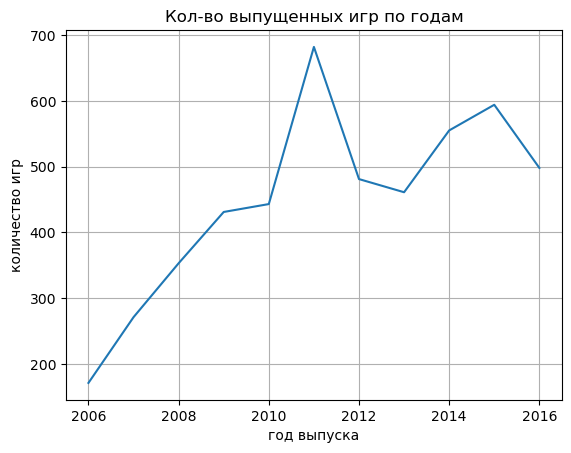

In [40]:
games.groupby('year_of_release')['name'].count().plot(grid=True)
plt.title('Кол-во выпущенных игр по годам')
plt.xlabel('год выпуска')
plt.ylabel('количество игр')
plt.show()

Видно, что с годами количество выпущенных игр растет и достигает своего пика около 2010 года. <br>
Для анализа не требуются данные за всё время выпуска игр, так как со временем пользовательское поведение и предпочтения меняются, так что слишком старые данные могут испортить прогноз.

<h3>Популярность платформ с течением времени</h3>

In [17]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)

platform
PS2     1255.77
X360     971.42
PS3      939.64
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64

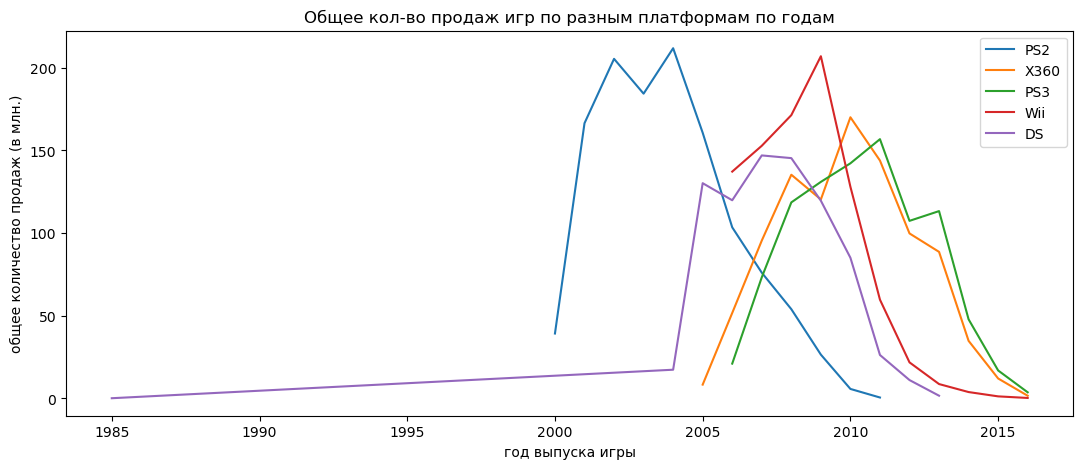

In [18]:
plt.figure(figsize=(13, 5))

for k in games.groupby('platform', as_index=False)['total_sales'].sum().sort_values(by='total_sales', ascending=False)['platform'].head(5):
    games.query('platform == @k').groupby('year_of_release')['total_sales'].sum().plot.line()
    plt.legend(k)

plt.legend(games.groupby('platform', as_index=False)['total_sales'].sum().sort_values(by='total_sales', ascending=False)['platform'].head(5))
plt.title('Общее кол-во продаж игр по разным платформам по годам')
plt.xlabel('год выпуска игры')
plt.ylabel('общее количество продаж (в млн.)')
plt.show()

Если смотреть на распределение продаж игр пяти платформ с наибольшими сумарными продажами, то можно увидеть схожесть в длине графиков по оси X. В среднем платформа живет 10 лет.<br>
Исходя из этой информации, будем брать данные по 2006 год, то есть за последние 10 лет.

In [19]:
games = games.query('2005 < year_of_release')
modern_platforms = games.query('year_of_release > 2014').groupby('platform', as_index=False)['total_sales'].sum().query('total_sales > 3')['platform']

games = games.query('platform in @modern_platforms')

C:\Users\stepa\AppData\Local\Temp\ipykernel_10544\769772443.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  games = games.query('2005 < year_of_release')
C:\Users\stepa\AppData\Local\Temp\ipykernel_10544\769772443.py:2: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  modern_platforms = games.query('year_of_release > 2014').groupby('platform', as_index=False)['total_sales'].sum().query('total_sales > 3')['platform']


<h3>Популярность плтаформ в актуальном периоде</h3>

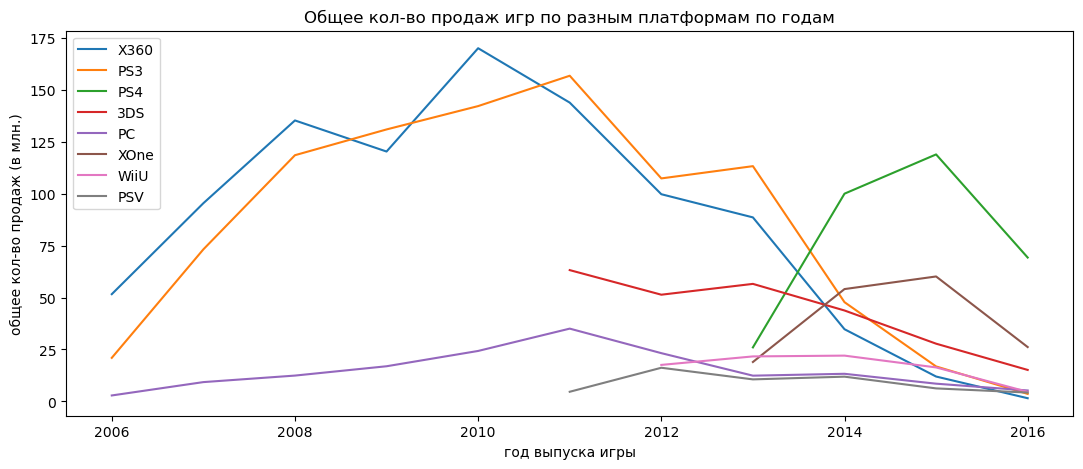

In [20]:
plt.figure(figsize=(13, 5))

for k in games.groupby('platform', as_index=False)['total_sales'].sum().sort_values(by='total_sales', ascending=False)['platform'].head(10):
    games.query('platform == @k').groupby('year_of_release')['total_sales'].sum().plot.line()
    plt.legend(k)

plt.legend(games.groupby('platform', as_index=False)['total_sales'].sum().sort_values(by='total_sales', ascending=False)['platform'].head(10))
plt.title('Общее кол-во продаж игр по разным платформам по годам')
plt.xlabel('год выпуска игры')
plt.ylabel('общее кол-во продаж (в млн.)')
plt.show()

Для того, чтобы найти актуальные лидирующие платформы, я:
<ul>
<li>Взял данные с 2006 года включительно.</li>
<li>Убрал платформы, у которых за последние 2 года менее 3 млн. продаж, чтобы не брать в расчет "мертвые" платформы.</li>
<li>Построил график распределения продаж игр по оставшимся платформам.</li>
</ul>
Исходя из графика, можно сделать вывод, что за последние 2-3 года снижаются продажи игр практически по всем платформам кроме XboxOne и PS4. За 2016 год видно снижение продаж всех платформ, вероятнее всего, это связано с неполнотой данных.<br>
Потенциально прибыльные платформы - PS4 и XboxOne. Они являются лидерами продаж в 2015 и 2016 годах, только у них наблюдался рост продаж в 2015 году.

<h3>Распределение общего количества продаж игр в зависимости от платформы</h3>

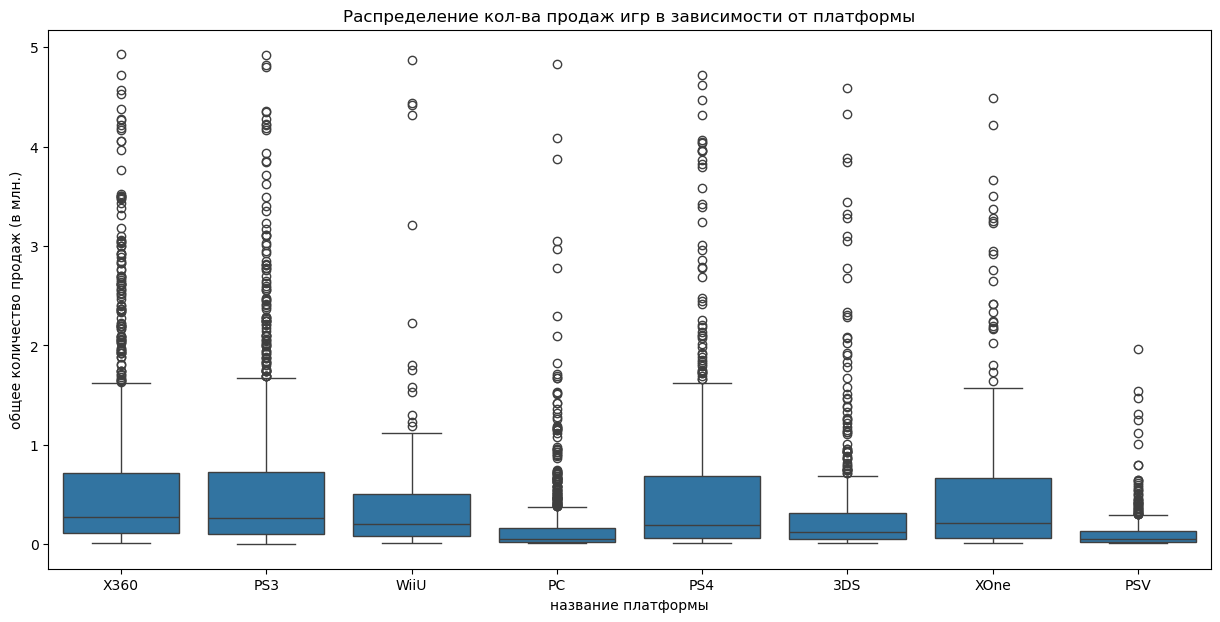

In [39]:
plt.figure(figsize=(15,7))

sns.boxplot(data=games, x='platform', y='total_sales')

plt.title('Распределение кол-ва продаж игр в зависимости от платформы')
plt.xlabel('название платформы')
plt.ylabel('общее количество продаж (в млн.)')
plt.show()

<p>Графики по разным платформам выглядят похоже. Очень малая медиана и огромные выбросы. Вероятнее всего, это связано со спецификой игровой индустрии. Выпускается много игр, однако большинство из них практически не имеет продаж. Все продажи сосредоточены у небольшого количества хитов.</p>
Ограничим общий тираж значением в 5 млн., чтобы уменьшить влияние выбросов на исследование. Таким образом, мы лишимся всего 2% данных.

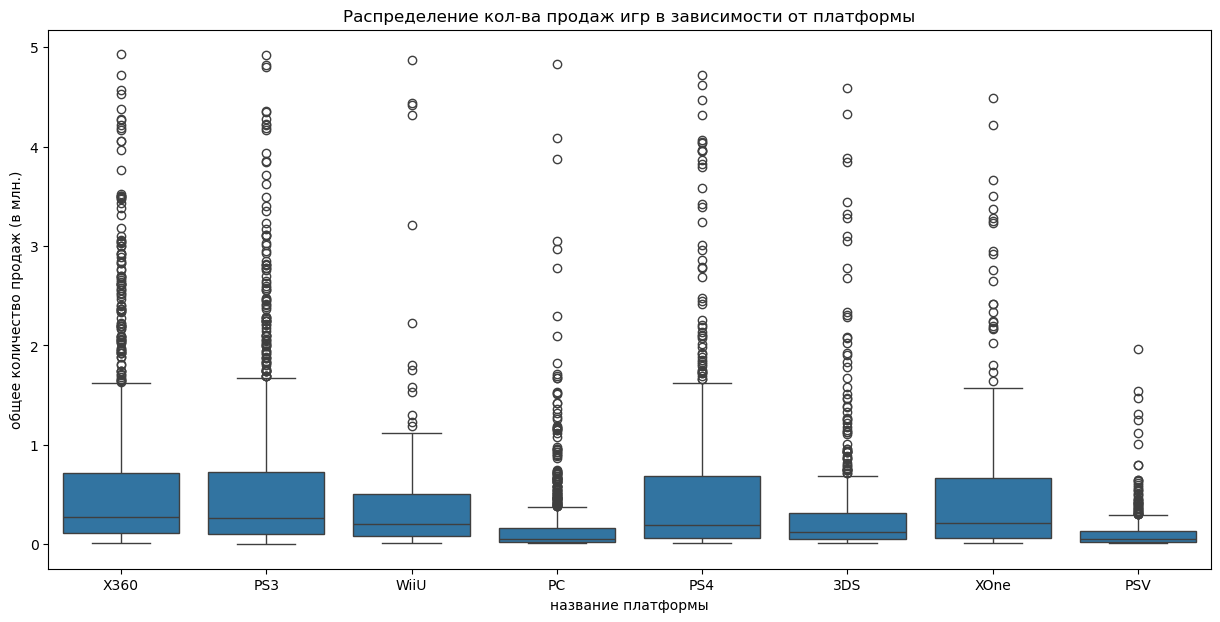

In [38]:
games = games.query('total_sales < 5')

plt.figure(figsize=(15,7))

sns.boxplot(data=games, x='platform', y='total_sales')

plt.title('Распределение кол-ва продаж игр в зависимости от платформы')
plt.xlabel('название платформы')
plt.ylabel('общее количество продаж (в млн.)')
plt.show()

Теперь графики выглядят более наглядно.

<h3>Влияние оценок пользователей и критиков на общее количество продаж</h3>

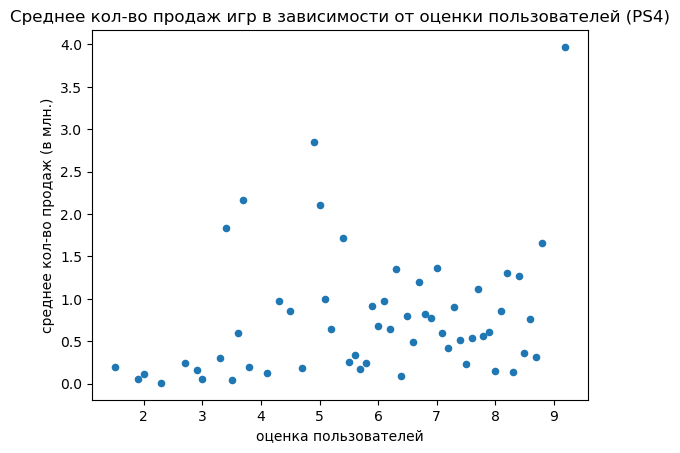

In [37]:
games.query('platform == "PS4"').groupby('user_score', as_index=False)['total_sales'].mean().plot(kind='scatter', x='user_score', y='total_sales')
plt.title('Среднее кол-во продаж игр в зависимости от оценки пользователей (PS4)')
plt.xlabel('оценка пользователей')
plt.ylabel('среднее кол-во продаж (в млн.)')
plt.show()

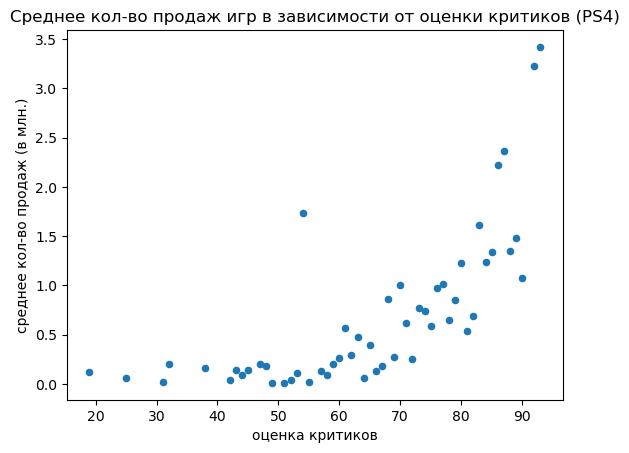

In [42]:
games.query('platform == "PS4"').groupby('critic_score', as_index=False)['total_sales'].mean().plot(kind='scatter', x='critic_score', y='total_sales')
plt.title('Среднее кол-во продаж игр в зависимости от оценки критиков (PS4)')
plt.xlabel('оценка критиков')
plt.ylabel('среднее кол-во продаж (в млн.)')
plt.show()

In [46]:
games.query('platform == "PS4"').drop(['name','platform','genre', 'rating'], axis=1).groupby('critic_score', as_index=False).mean().corr()['total_sales'][0]

C:\Users\stepa\AppData\Local\Temp\ipykernel_10544\3655578133.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  games.query('platform == "PS4"').drop(['name','platform','genre', 'rating'], axis=1).groupby('critic_score', as_index=False).mean().corr()['total_sales'][0]


0.7073986052672906

In [47]:
games.query('platform == "PS4"').drop(['name','platform','genre', 'rating'], axis=1).groupby('user_score', as_index=False).mean().corr()['total_sales'][0]

C:\Users\stepa\AppData\Local\Temp\ipykernel_10544\3877499325.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  games.query('platform == "PS4"').drop(['name','platform','genre', 'rating'], axis=1).groupby('user_score', as_index=False).mean().corr()['total_sales'][0]


0.2620035341948498

Если смотреть на корреляцию оценок критиков и пользователей с средним общим количеством продаж игр на платформе PS4, то можно сделать вывод, что: 
<ul>
<li>оценки пользователей практически не коррелируют с общим количеством продаж;</li>
<li>оценки критиков имеют средний уровень корреляции, то есть влияют на общее количество продаж.</li>
</ul>

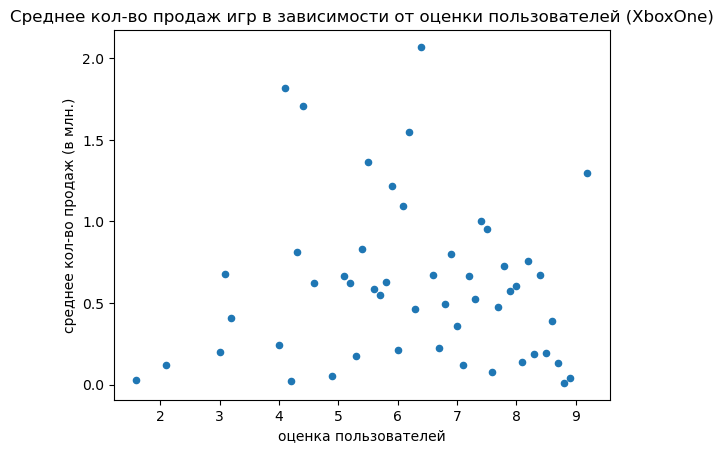

In [50]:
games.query('platform == "XOne"').groupby('user_score', as_index=False)['total_sales'].mean().plot(kind='scatter', x='user_score', y='total_sales')
plt.title('Среднее кол-во продаж игр в зависимости от оценки пользователей (XboxOne)')
plt.xlabel('оценка пользователей')
plt.ylabel('среднее кол-во продаж (в млн.)')
plt.show()

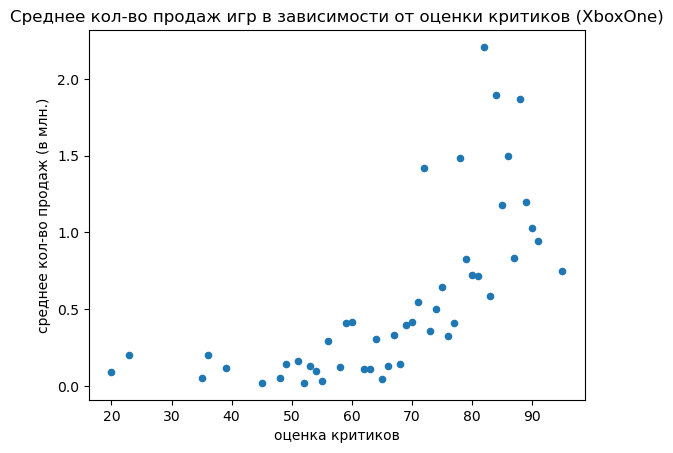

In [52]:
games.query('platform == "XOne"').groupby('critic_score', as_index=False)['total_sales'].mean().plot(kind='scatter', x='critic_score', y='total_sales')
plt.title('Среднее кол-во продаж игр в зависимости от оценки критиков (XboxOne)')
plt.xlabel('оценка критиков')
plt.ylabel('среднее кол-во продаж (в млн.)')
plt.show()

In [53]:
games.query('platform == "XOne"').drop(['name','platform','genre', 'rating'], axis=1).groupby('critic_score', as_index=False).mean().corr()['total_sales'][0]

C:\Users\stepa\AppData\Local\Temp\ipykernel_10544\57258659.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  games.query('platform == "XOne"').drop(['name','platform','genre', 'rating'], axis=1).groupby('critic_score', as_index=False).mean().corr()['total_sales'][0]


0.6846935695919739

In [54]:
games.query('platform == "XOne"').drop(['name','platform','genre', 'rating'], axis=1).groupby('user_score', as_index=False).mean().corr()['total_sales'][0]

C:\Users\stepa\AppData\Local\Temp\ipykernel_10544\573945216.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  games.query('platform == "XOne"').drop(['name','platform','genre', 'rating'], axis=1).groupby('user_score', as_index=False).mean().corr()['total_sales'][0]


-0.03893322819924997

На примере второй популярной платформы XboxOne, можно подтвердить выводы:
<ul>
<li>оценки пользователей не коррелируют с общим количеством продаж;</li>
<li>оценки критиков имеют средний уровень корреляции, то есть влияют на общее количество продаж.</li>
</ul>

<h3>Общее распределение игр по жанрам</h3>

In [55]:
games['genre'].value_counts()

genre
Action          1442
Sports           592
Shooter          536
Role-Playing     512
Misc             399
Adventure        351
Racing           297
Strategy         213
Fighting         203
Simulation       196
Platform         138
Puzzle            61
Name: count, dtype: int64

In [56]:
games.groupby('genre')['total_sales'].median().sort_values(ascending=False)

genre
Shooter         0.340
Fighting        0.300
Sports          0.250
Platform        0.235
Racing          0.190
Action          0.170
Role-Playing    0.170
Misc            0.150
Simulation      0.120
Puzzle          0.050
Strategy        0.050
Adventure       0.040
Name: total_sales, dtype: float64

Самыми популярными жанрами являются экшен, спорт и шутеры, а самыми непопулярными - пазл, платформеры и симуляторы.<br>
По медианному уровню продаж лидируют шутеры, файтинги и спортивные игры. Наименьшие средние продажи у игр жанра приключение, стратегия и пазл.

<h2>Портрет пользователя каждого региона</h2>

<h3>Самые популярные платформы в разных регионах</h3>

Text(0.5, 0, 'всего продаж в регионе (в млн.)')

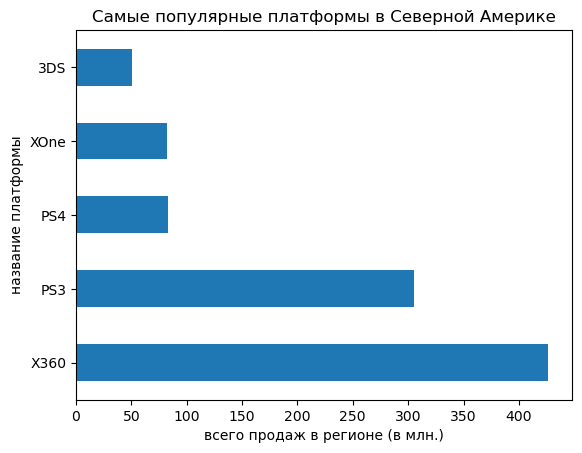

In [57]:
games.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Самые популярные платформы в Северной Америке')
plt.ylabel('название платформы')
plt.xlabel('всего продаж в регионе (в млн.)')
plt.show()

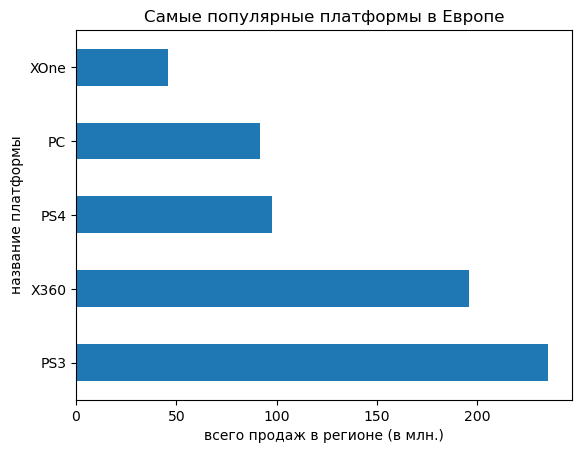

In [58]:
games.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Самые популярные платформы в Европе')
plt.ylabel('название платформы')
plt.xlabel('всего продаж в регионе (в млн.)')
plt.show()

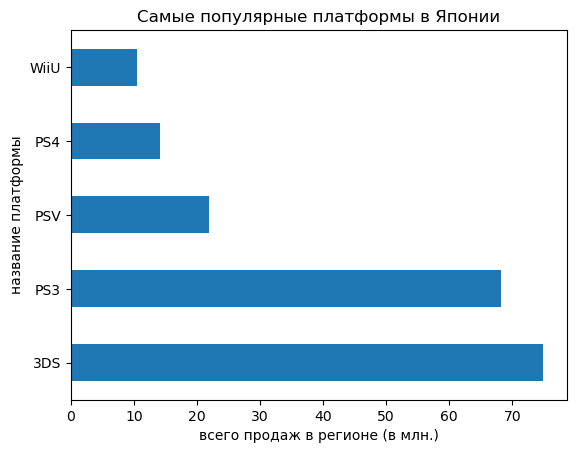

In [59]:
games.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Самые популярные платформы в Японии')
plt.ylabel('название платформы')
plt.xlabel('всего продаж в регионе (в млн.)')
plt.show()

Отчасти самые популярные платформы среди регионов сходятся, PS3 и PS4 есть в топе всех регионов, однако имеются и отличия:
<ul>
<li>Самыми популярными платформами в Северной Америке являются линейки консолей от Sony и Microsoft - Xbox и PS. На 5 месте находится портативная консоль от Nintendo.</li>
<li>Распределение в Европе напоминает Северную Америку, в топ 3 входят консоли от Sony и Microsoft, а 5 место занимает Nintendo. Однако в Европе 4 место занимает PC, то есть игры на персональных компьютерах.</li>
<li>Топ Японии отличается от других регионов больше всех. Самыми популярными платформами здесь являются портативные консоли от Nintendo, а также PSV. При этом все 5 мест занимают консоли, которые производят японские компании: Sony и Nintendo. Только в этом регионе в топ входят сразу два вида консолей от Nintendo.</li>
</ul>

<h3>Самые популярные жанры в разных регионах</h3>

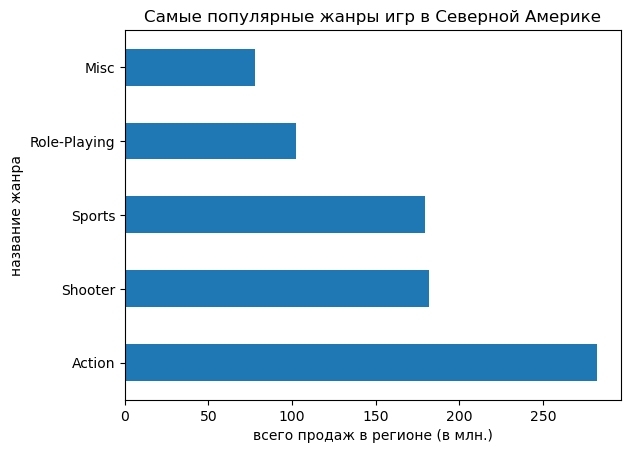

In [60]:
games.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Самые популярные жанры игр в Северной Америке')
plt.ylabel('название жанра')
plt.xlabel('всего продаж в регионе (в млн.)')
plt.show()

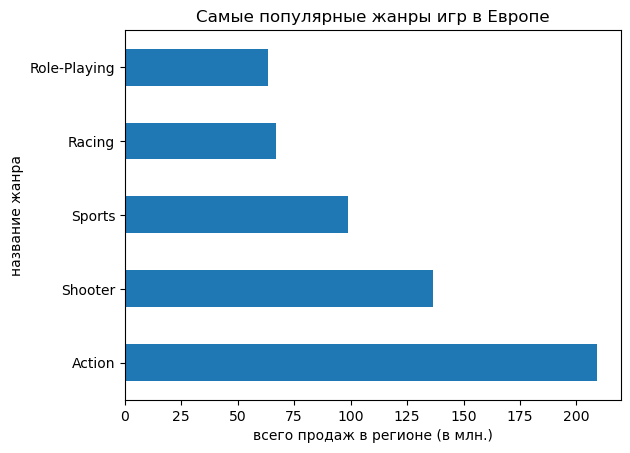

In [61]:
games.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Самые популярные жанры игр в Европе')
plt.ylabel('название жанра')
plt.xlabel('всего продаж в регионе (в млн.)')
plt.show()

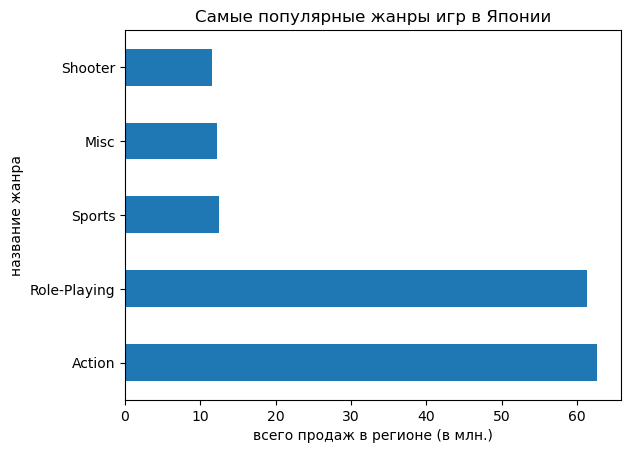

In [62]:
games.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Самые популярные жанры игр в Японии')
plt.ylabel('название жанра')
plt.xlabel('всего продаж в регионе (в млн.)')
plt.show()

<p>Самые популярные жанры среди регионов имеют больше сходств, чем платформы. Во всех регионах в разном порядке находятся жанры: экшен, шутер, спорт и рпг. Среди отличительного жанра: в Северной Америке и Японии - разное, в Европе - гонки.</p>
<p>Топ Японии наибольшее различие, так как на втором месте там находится жанр рпг, при этом он почти догнал по продажам жанр экшен.</p>

<h3>Влияние рейтинга ESRB на количество продаж в разных регионах</h3>

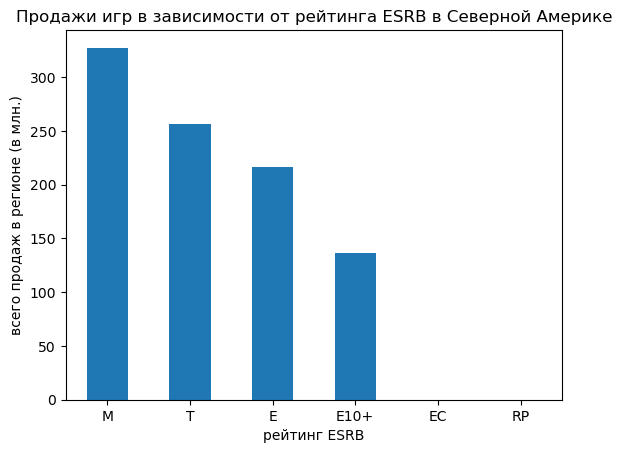

In [63]:
games.groupby('rating')['na_sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Продажи игр в зависимости от рейтинга ESRB в Северной Америке')
plt.xlabel('рейтинг ESRB')
plt.ylabel('всего продаж в регионе (в млн.)')
plt.show()

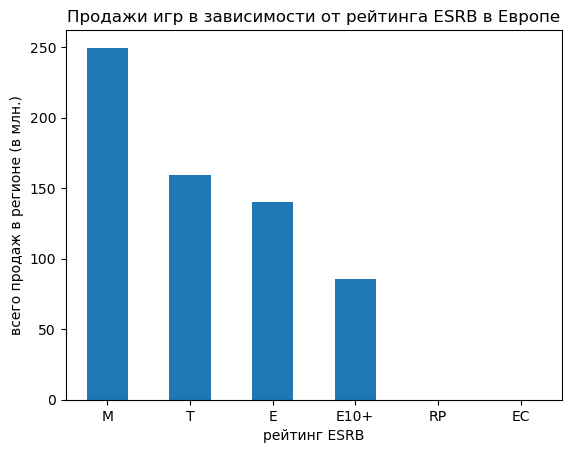

In [64]:
games.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Продажи игр в зависимости от рейтинга ESRB в Европе')
plt.xlabel('рейтинг ESRB')
plt.ylabel('всего продаж в регионе (в млн.)')
plt.show()

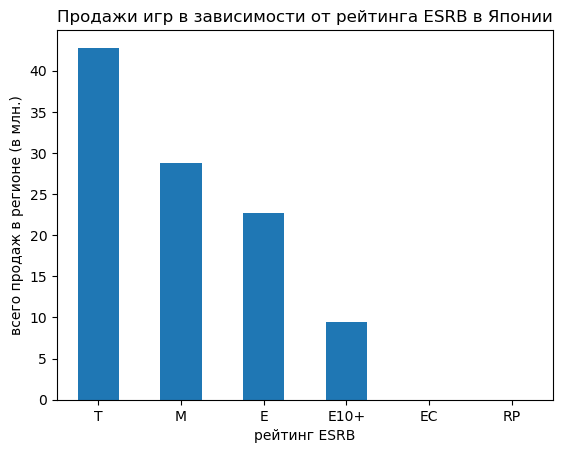

In [65]:
games.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Продажи игр в зависимости от рейтинга ESRB в Японии')
plt.xlabel('рейтинг ESRB')
plt.ylabel('всего продаж в регионе (в млн.)')
plt.show()

Графики практически одинаковы, больше всего покупают игры с рейтингом M, E и T, так как пользователи этих групп наиболее многочислены. Нет оснований предполагать, что рейтинг ESRB влияет на продажи в отдельном регионе.

<h2>Проверка гипотез</h2>

<h3>Средние пользовательские рейтинги платформ Xbox One и PC одинаковые</h3>

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные.

In [66]:
print('Средний пользовательский рейтинг XboxOne', games.query('platform == "XOne"')['user_score'].mean())
print('Средний пользовательский рейтинг PC', games.query('platform == "PC"')['user_score'].mean())

user_score_xone = games.query('platform == "XOne" and user_score.notna()')['user_score']
user_score_pc = games.query('platform == "PC" and user_score.notna()')['user_score']
alpha = 0.05

results = st.ttest_ind(user_score_xone, user_score_pc)

print('pvalue:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг XboxOne 6.52
Средний пользовательский рейтинг PC 6.833442088091354
pvalue: 0.013262619669870511
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу альтернативной, средние пользовательские рейтинги платформ Xbox One и PC - разные.

<h3>Средние пользовательские рейтинги жанров экшен и спорт разные</h3>

Нулевая гипотеза: средние пользовательские рейтинги жанров экшен и спорт одинаковые.<br>
Альтернативная гипотеза: средние пользовательские рейтинги жанров экшен и спорт разные.

In [67]:
print('Средний пользовательский рейтинг жанра экшен', games.query('genre == "Action"')['user_score'].mean())
print('Средний пользовательский рейтинг жанра спорт', games.query('genre == "Sports"')['user_score'].mean())

user_score_action = games.query('genre == "Action" and user_score.notna()')['user_score']
user_score_sports = games.query('genre == "Sports" and user_score.notna()')['user_score']

results = st.ttest_ind(user_score_action, user_score_sports)

print('pvalue:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг жанра экшен 6.837540453074434
Средний пользовательский рейтинг жанра спорт 6.099528301886793
pvalue: 2.512541399790041e-18
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу в пользу альтернативной, средние пользовательские рейтинги жанров экшен и спорт - разные.

<p>Сформулировал нулевую и альтернативные гипотезы исходя из предположения, которое нужно было проверить. Во втором случаем в качестве нулевой гипотезы поставил равенство, а не разность, так как метод проверяет именно равенство средних двух ГС.</p> 
<p>Для проверки гипотез использовал двухвыборочный t-тест для независимых выборок, так как нам нужно проверить гипотезу о равенстве средних двух независимых ГС.</p>

<h2>Общий вывод</h2>

Изначальные данные были обработаны для дальнейшего анализа:
<ul>
<li>Заполнил пропуски в столбцах с рейтингом пользователей и критиков.</li>
<li>Перевел значения года и оценки критиков в целочисленный формат.</li>
<li>Проверил наличие полных дубликатов.</li>
<li>Добавил столбец с общим количеством продаж игры.</li>
</ul>
Затем был проведен исследовательский анализ данных, были проанализрованы:
<ul>
<li>Количество выпущенных игр в разные годы. Значение увеличивается примерно до 2008 года, а затем идет на спад.</li>
<li>Популярность платформ с течением времени. В среднем платформа живет около 10 лет.</li>
<li>Популярность плтаформ в актуальном периоде. Потенциально прибыльные платформы - PS4 и XboxOne.</li>
<li>Распределение общего количества продаж игр в зависимости от платформы. Медиана большинства платформ находится на уровне 0.3 млн. продаж всего.</li>
<li>Влияние оценок пользователей и критиков на общее количество продаж. Оценки критиков влияют на общее количество продаж, а оценки пользователей - нет.</li>
<li>Общее распределение игр по жанрам. Самые популярные жанры - экшен и спорт, а самые прибыльные - шутеры и спорт.</li>
</ul>
Затем был проанализирован портрет пользователя каждого региона, а именно:
<ul>
<li>Самые популярные платформы в разных регионах.</li>
<li>Самые популярные жанры в разных регионах.</li>
<li>Влияние рейтинга ESRB на количество продаж в разных регионах.</li>
</ul>
Были проверены гипотезы и сделаны выводы:
<ul>
<li>Средние пользовательские рейтинги платформ Xbox One и PC - разные.</li>
<li>Средние пользовательские рейтинги жанров экшен и спорт - разные.</li>
</ul>